# **Install necessary packages**

In [1]:
!pip install cassandra-driver
!python -c 'import cassandra; print ("cassandra driver version = " + cassandra.__version__)'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 25.5 MB/s 
cassandra driver version = 3.25.0


# **Import Libraries and Dataset**

In [1]:
# Log file created here
import logging

logger = logging.getLogger()

file_handler = logging.FileHandler(filename='scr_fem_log.log', mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.setLevel(logging.DEBUG)
logger.info('FILE STARTS RUNNING!')

INFO:root:FILE STARTS RUNNING!


In [2]:
import cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import os
import csv
import sys

import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [3]:
logger.info('Libraries imported..')

INFO:root:Libraries imported..


**Connect to Cassandra database**

In [4]:
logger.info('Connecting to database..')

INFO:root:Connecting to database..


In [5]:
ASTRA_DB_TOKEN="AstraCS:iQyLbOiYUpxBBjOpKxYMKvnQ"
ASTRA_DB_SECURE_BUNDLE_LOCATION="/content/secure-connect-ineuron-3.zip"

!env | grep ASTRA

In [6]:
username = "token"
token = ASTRA_DB_TOKEN
secureBundleLocation = ASTRA_DB_SECURE_BUNDLE_LOCATION

In [7]:
# Database Name : Ineuron_3

keyspace = 'german_credit'

table_name = 'gcr2'

client_id = 'iQyLbOiYUpxBBjOpKxYMKvnQ'

client_secret = '6RXh7D4EW,3KrwO_xGASH0ElpjiLBQYH97SzAgatFMN,EXxYlPWMm96LtB1RIE_fm6bPyClhM74kDtXdBAt3LegqcCdErrU_Jj9OsH9OSW+2J1G+FOG4yop8uim9v0Go'

cloud_config = {'secure_connect_bundle':'/content/secure-connect-ineuron-3.zip'}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

DEBUG:cassandra.cluster:Connecting to cluster, contact points: [<SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65>, <SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7>, <SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b>]; protocol version: 66
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65 is now marked up
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7 is now marked up
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b is now marked up
DEBUG:cassandra.cluster:[control connection] Opening 

In [8]:
logger.info('Database Connected.')

INFO:root:Database Connected.


In [9]:
session.execute("USE {keyspace};".format(keyspace=keyspace))

DEBUG:cassandra.connection:Sending initial options message for new connection (140578352526992) to 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b


In [10]:
logger.info('Extracting data from database..')

INFO:root:Extracting data from database..


In [11]:
def pandas_factory(colnames, rows):
  return pd.DataFrame(rows, columns=colnames)

session.row_factory = pandas_factory
session.default_fetch_size = None

result = session.execute("SELECT * FROM {table_name};".format(table_name=table_name), timeout=None)

df=result._current_rows.sort_values('id')
df.head()

DEBUG:cassandra.connection:Received options response on new connection (140578352526992) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:No available compression types supported on both ends. locally supported: odict_keys([]). remotely supported: ['snappy', 'lz4']
DEBUG:cassandra.connection:Sending StartupMessage on <LibevConnection(140578352526992) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b>
DEBUG:cassandra.connection:Sent StartupMessage on <LibevConnection(140578352526992) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b>
DEBUG:cassandra.connection:Got AuthenticateMessage on new connection (140578352526992) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b: org.apache.cassandra.auth.Pas

,id,age,amount,credit_history,credit_risk,duration,employment_duration,foreign_worker,housing,other_debtors,other_installment_plans,personal_status_sex,property,purpose,savings,status
296,0,21,1049,4,1,18,2,2,1,1,3,2,2,2,1,1
255,1,36,2799,4,1,9,3,2,1,1,3,3,1,0,1,1
312,2,23,841,2,1,12,4,2,1,1,3,2,1,9,2,2
989,3,39,2122,4,1,12,3,1,1,1,3,3,1,0,1,1
339,4,38,2171,4,1,12,3,1,2,1,1,3,2,0,1,1


In [12]:
logger.info('Data extraction completed.')

INFO:root:Data extraction completed.


# **Feature Engineering**

In [13]:
logger.info('Feature engineering started..')

INFO:root:Feature engineering started..


**Encoding categorical variables**

In [14]:
cat_vars = ['credit_history', 'status', 'purpose', 'savings', 'employment_duration', 'personal_status_sex',
            'other_debtors', 'property', 'other_installment_plans', 'housing', 'foreign_worker']

In [15]:
# Encoding categorical variables
df_engineered = pd.get_dummies(df,columns=cat_vars).drop('id', axis=1)

df_engineered.head()

,age,amount,credit_risk,duration,credit_history_0,credit_history_1,credit_history_2,credit_history_3,credit_history_4,status_1,...,property_3,property_4,other_installment_plans_1,other_installment_plans_2,other_installment_plans_3,housing_1,housing_2,housing_3,foreign_worker_1,foreign_worker_2
296,21,1049,1,18,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,0,1
255,36,2799,1,9,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,0,1
312,23,841,1,12,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,1
989,39,2122,1,12,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,0
339,38,2171,1,12,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,1,0


We shall scale the numeric columns after we separate the data into independent and dependent variables, prior to modeling.

In [16]:
logger.info('Feature engineering completed.')

INFO:root:Feature engineering completed.


# **Modeling**

In [17]:
logger.info('Modeling started.')

INFO:root:Modeling started.


In [18]:
X = df_engineered.drop('credit_risk', axis=1)
y= df_engineered['credit_risk']

In [19]:
#standardise the x value by using standardscaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Checking the target rate in the population, train sample and test sample
print("Population risk rate :", 
      round(sum(df_engineered.credit_risk)*100/len(df_engineered), 2),"%")
print("Train set risk rate :", 
      round(sum(y_train)*100/len(y_train), 2),"%")
print("Test set risk rate :", 
      round(sum(y_test)*100/len(y_test), 2),"%")

Population risk rate : 70.0 %
Train set risk rate : 70.29 %
Test set risk rate : 69.33 %


The target rates seem to be satifactory, as all the values are almost close by.

This means, there is approximately 70% Good Risk and 30% Bad Risk values in population, train set and test set data.

## **Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()

# Training the model
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Predict on test data
y_pred = lr_clf.predict(X_test)

In [24]:
# Evaluation metrics
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55        92
           1       0.79      0.88      0.83       208

    accuracy                           0.76       300
   macro avg       0.71      0.68      0.69       300
weighted avg       0.75      0.76      0.75       300

[[ 45  47]
 [ 26 182]]
Accuracy : 0.7566666666666667
F1-score :  0.8329519450800915
ROC-AUC Score : 0.6820652173913043


In [25]:
# Calculate average F1 score on the entire data
from sklearn.model_selection import cross_val_score

f1 =cross_val_score(lr_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.8


## **Random Forest Classifier**

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Training the model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
# Predictions on test data
y_pred = rf_clf.predict(X_test)

In [28]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.43      0.53        92
           1       0.78      0.90      0.84       208

    accuracy                           0.76       300
   macro avg       0.72      0.67      0.68       300
weighted avg       0.75      0.76      0.74       300

[[ 40  52]
 [ 20 188]]
Accuracy : 0.76
F1-score :  0.8392857142857143
ROC-AUC Score : 0.669314381270903


In [29]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(rf_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.82


## **Adaboost Classifier**

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=4)
ab_clf = AdaBoostClassifier(base_estimator=dt_clf)

# Training the model
ab_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4))

In [31]:
# Predictions on test data
y_pred = ab_clf.predict(X_test)

In [32]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.40      0.46        92
           1       0.76      0.85      0.80       208

    accuracy                           0.71       300
   macro avg       0.65      0.62      0.63       300
weighted avg       0.69      0.71      0.70       300

[[ 37  55]
 [ 32 176]]
Accuracy : 0.71
F1-score :  0.8018223234624144
ROC-AUC Score : 0.6241638795986622


In [33]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(ab_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.77


## **XGBoost Classifier**

In [34]:
from xgboost import XGBClassifier

In [35]:
# Training the model
xgb_clf=XGBClassifier(objective='binary:logistic', booster='gbtree')
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [36]:
# Predicting on test data
y_pred = xgb_clf.predict(X_test)

In [37]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.50      0.56        92
           1       0.80      0.88      0.84       208

    accuracy                           0.76       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.75      0.76      0.75       300

[[ 46  46]
 [ 25 183]]
Accuracy : 0.7633333333333333
F1-score :  0.8375286041189931
ROC-AUC Score : 0.6899038461538461


In [38]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(xgb_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.82


## **Naive Bayes**

In [39]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Training the model
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)

GaussianNB()

In [40]:
# Predicting on test data
y_pred = gnb_clf.predict(X_test)

In [41]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.75      0.61        92
           1       0.86      0.69      0.77       208

    accuracy                           0.71       300
   macro avg       0.69      0.72      0.69       300
weighted avg       0.76      0.71      0.72       300

[[ 69  23]
 [ 64 144]]
Accuracy : 0.71
F1-score :  0.768
ROC-AUC Score : 0.7211538461538461


In [42]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(gnb_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.7


## **SVM**

In [43]:
from sklearn import svm

# training the model
svc_clf = svm.SVC(kernel='rbf')
svc_clf.fit(X_train, y_train)

SVC()

In [44]:
# Predicting on test data
y_pred = svc_clf.predict(X_test)

In [45]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49        92
           1       0.77      0.92      0.84       208

    accuracy                           0.76       300
   macro avg       0.73      0.65      0.66       300
weighted avg       0.75      0.76      0.73       300

[[ 35  57]
 [ 16 192]]
Accuracy : 0.7566666666666667
F1-score :  0.8402625820568929
ROC-AUC Score : 0.6517558528428093


In [46]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(svc_clf, X , y, cv=10, scoring='f1')
print('\nFinal Average F1 score of the model:', round(f1.mean(),2))


Final Average F1 score of the model: 0.83


In [47]:
logger.info('Initial modeling phase ends..')

INFO:root:Initial modeling phase ends..


# **Modeling Phase 2**

In [48]:
logger.info('Selected best model..')

INFO:root:Selected best model..


When we look at the confusion matrix and scores(especially f1-score) of the various models, we observe that the XGBoost classifier and Naive Bayes classifier performs perhaps better.

We shall take XGBoost classifier for our problem. 

Lets start with 

 **Feature Importance**

In [49]:
logger.info('Important features selecting..')

INFO:root:Important features selecting..


NameError: ignored

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal

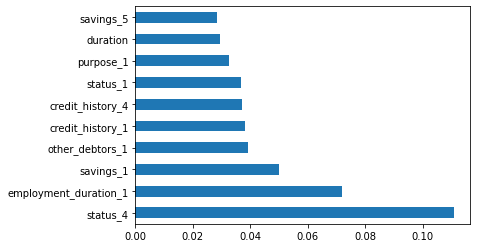

In [51]:
# Finding the important features
feature_importances_xgb = pd.Series(xgb_clf.feature_importances_, index=df_engineered.drop('credit_risk',axis=1).columns)
feature_importances_xgb.nlargest(10).plot(kind='barh')
plt.show()

**Modeling**

In [52]:
df_engineered.shape

(1000, 52)

In [53]:
# Top 30 important features
new_features = feature_importances_xgb.nlargest(30)

In [54]:
logger.info('Important features selected.')

INFO:root:Important features selected.


In [56]:
new_features.index

Index(['status_4', 'employment_duration_1', 'savings_1', 'other_debtors_1',
       'credit_history_1', 'credit_history_4', 'status_1', 'purpose_1',
       'duration', 'savings_5', 'purpose_0', 'property_4',
       'other_installment_plans_3', 'other_debtors_3', 'property_1',
       'other_debtors_2', 'employment_duration_2', 'amount', 'purpose_6',
       'age', 'savings_4', 'credit_history_3', 'employment_duration_4',
       'credit_history_0', 'property_2', 'housing_1', 'status_3',
       'employment_duration_5', 'personal_status_sex_3', 'housing_2'],
      dtype='object')

In [57]:
# Final data for our modeling
df_final = df_engineered[new_features.index]
df_final['credit_risk'] = df_engineered['credit_risk']
df_final.head(3)

,status_4,employment_duration_1,savings_1,other_debtors_1,credit_history_1,credit_history_4,status_1,purpose_1,duration,savings_5,...,credit_history_3,employment_duration_4,credit_history_0,property_2,housing_1,status_3,employment_duration_5,personal_status_sex_3,housing_2,credit_risk
296,0,0,1,1,0,1,1,0,18,0,...,0,0,0,1,1,0,0,0,0,1
255,0,0,1,1,0,1,1,0,9,0,...,0,0,0,0,1,0,0,1,0,1
312,0,0,0,1,0,0,0,0,12,0,...,0,1,0,0,1,0,0,0,0,1


In [58]:
# Rearranging the columns
df_final = df_final[['duration', 'amount', 'age', 'status_1', 'status_3', 'status_4', 'employment_duration_1', 'employment_duration_2',
            'employment_duration_4', 'employment_duration_5', 'savings_1', 'savings_4', 'savings_5',
            'other_debtors_1', 'other_debtors_2', 'other_debtors_3', 'credit_history_0', 'credit_history_1', 'credit_history_3',
            'credit_history_4', 'purpose_0', 'purpose_1', 'purpose_6', 'property_1', 'property_2', 'property_4',
            'other_installment_plans_3', 'housing_1', 'housing_2', 'personal_status_sex_3', 'credit_risk']]
df_final.head(3)

,duration,amount,age,status_1,status_3,status_4,employment_duration_1,employment_duration_2,employment_duration_4,employment_duration_5,...,purpose_1,purpose_6,property_1,property_2,property_4,other_installment_plans_3,housing_1,housing_2,personal_status_sex_3,credit_risk
296,18,1049,21,1,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,1
255,9,2799,36,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1
312,12,841,23,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1


In [59]:
X = df_final.drop('credit_risk', axis=1).values
y = df_final['credit_risk'].values

DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (140645114987280) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65
DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (140645114986704) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7
DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (140645093192656) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (140645115347600) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Received options response on connection (140645115347600) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.data

In [61]:
#standardise the x value by using standardscaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
# Training the model
xgb_clf2 = XGBClassifier(objective='binary:logistic', booster='gbtree')
xgb_clf2.fit(X_train, y_train)

XGBClassifier()

In [64]:
# Predicting on test data
y_pred = xgb_clf2.predict(X_test)

In [65]:
# Evaluation metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57        92
           1       0.80      0.87      0.83       208

    accuracy                           0.76       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.75      0.76      0.75       300

[[ 48  44]
 [ 28 180]]
Accuracy : 0.76
F1-score :  0.8333333333333334
ROC-AUC Score : 0.6935618729096991


In [68]:
# Finding average F1 score on entire data using cross validation
f1 =cross_val_score(xgb_clf2, X , y, cv=10, scoring='f1')
print('\nFinal F1 score of the model:', round(f1.mean(),2))


Final F1 score of the model: 0.82


**Hyperparameter Tuning**

In [69]:
logger.info('Hyperparameter tuning starts..')

INFO:root:Hyperparameter tuning starts..


In [70]:
import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [71]:
# List of parameters
params={
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
        "n_estimators"     : [100, 300, 500]
       }

xgb_clf3 = XGBClassifier()
rs = RandomizedSearchCV(xgb_clf3,param_distributions=params,n_iter=5,scoring='f1',n_jobs=-1,cv=5,verbose=3)

In [72]:
from datetime import datetime
# Fitting the model
start_time = timer(None) # timing starts from this point for "start_time" variable
rs.fit(X,y)
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 4.33 seconds.


In [73]:
rs.best_estimator_

XGBClassifier(colsample_bytree=0.3, gamma=0.0, learning_rate=0.15,
              min_child_weight=7)

In [74]:
rs.best_params_

{'n_estimators': 100,
 'min_child_weight': 7,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [75]:
logger.info('Best parameter values extracted')

INFO:root:Best parameter values extracted


**Modeling with the obtained parameters**

In [76]:
logger.info('Modeling phase 2 starts..')

INFO:root:Modeling phase 2 starts..


In [77]:
xgb_clf4 = XGBClassifier(colsample_bytree=0.7, 
                         gamma=0.4, 
                         learning_rate= 0.1,
                         max_depth=15, 
                         min_child_weight=3,
                         n_estimators=300)

In [78]:
xgb_clf4.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, gamma=0.4, max_depth=15, min_child_weight=3,
              n_estimators=300)

In [79]:
y_pred = xgb_clf4.predict(X_test)

In [80]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('F1-score : ', metrics.f1_score(y_test, y_pred))
print('ROC-AUC Score :', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58        92
           1       0.81      0.86      0.83       208

    accuracy                           0.76       300
   macro avg       0.72      0.70      0.70       300
weighted avg       0.75      0.76      0.75       300

[[ 49  43]
 [ 29 179]]
Accuracy : 0.76
F1-score :  0.8325581395348838
ROC-AUC Score : 0.6965928093645485


In [82]:
f1 =cross_val_score(xgb_clf4, X , y, cv=10, scoring='f1')
print('\nFinal F1 score of the model:', round(f1.mean(),2))


Final F1 score of the model: 0.83


In [83]:
logger.info('Modeleing phase 2 completed.')

INFO:root:Modeleing phase 2 completed.


# **Save model and Push the final dataset to database**

**Saving the model**

In [ ]:
import pickle

In [ ]:
pickle.dump(xgb_clf4, open('crc.pkl', 'wb'))

In [ ]:
logger.info('Model saved for deployment.')

INFO:root:Model saved for deployment.
